# Training models to predict next year's IFI tax for each French city


In [1]:
# Mounting Google Drive for data access
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


  #### Reading data (clean process explained in details in reding.ipynb)

In [2]:
import pandas as pd, os

dtype_dict = {
    'Région': str, 'Départements': str, 'Code commune (INSEE)': str, 'Commune': str,
    'nombre de redevables': int, 'patrimoine moyen en €': int, 'impôt moyen en €': int,
    "patrimoine moyen en millions d'euros": float, "impôt moyen en milliers d'euros": float
}

path = '/content/drive/MyDrive/Godi.AI/Operations/Freelancer/Projets/Impots_sur_la_fortune/TensorFlow_Prediction_5YearFrench_IFI/TensorFlow_Prediction_5YearFrench_IFI/DataIn'
ificom_files = [f for f in os.listdir(path) if f.startswith('ificom')]

df_ificom = pd.concat([pd.read_excel(os.path.join(path, file), header=0, skiprows=1, dtype=dtype_dict).assign(filename=file)
    for file in ificom_files], ignore_index=True)

# Harmonizing columns
harmonization_dict = {'Départements': 'Département', 'Code commune (INSEE)': 'Code de la commune (INSEE)',
    'Commune': 'Nom de la commune', 'nombre de redevables': 'Nombre de redevables',
    'patrimoine moyen en €': 'Patrimoine moyen en €', 'impôt moyen en €': 'Impôt moyen en €'}
for col, alt_col in harmonization_dict.items():
    df_ificom[col] = df_ificom[col].fillna(df_ificom[alt_col])

df_ificom.drop(columns=list(harmonization_dict.values()), inplace=True)

# Convert units and drop redundant columns
df_ificom['patrimoine moyen en €'] = df_ificom['patrimoine moyen en €'].fillna(df_ificom['patrimoine moyen en millions d\'euros'] * 1_000_000)
df_ificom['impôt moyen en €'] = df_ificom['impôt moyen en €'].fillna(df_ificom['impôt moyen en milliers d\'euros'] * 1_000)
df_ificom.drop(['patrimoine moyen en millions d\'euros', 'impôt moyen en milliers d\'euros'], axis=1, inplace=True)

# Extract year
df_ificom['year'] = df_ificom['filename'].str.extract(r'-(\d{4})\.').astype(float)

# Rename columns and process
df_ificom.rename(columns={'Région': 'Region', 'Départements': 'Department', 'Code commune (INSEE)': 'Commune_Code_INSEE', 'Commune': 'City',
    'nombre de redevables': 'Number_of_Taxpayers', 'patrimoine moyen en €': 'Average_Assets_in_Euro',
    'impôt moyen en €': 'Average_Tax_in_Euro', 'filename': 'Source_File', 'year': 'Year'}, inplace=True)
df_ificom['Commune_Code_INSEE'] = df_ificom['Commune_Code_INSEE'].str.replace(' ', '', regex=False)

# Merge and update 'City'
unique_grouped_sorted = pd.read_excel(
    os.path.join(path, 'unique_grouped_sorted.xlsx'), dtype=str)[['Commune_Code_INSEE', 'Final_City']].drop_duplicates()
df_ificom = df_ificom.merge(unique_grouped_sorted, on='Commune_Code_INSEE', how='left')
df_ificom['City'] = df_ificom['City'].fillna(df_ificom['Final_City'])
df_ificom.drop(columns=['Final_City'], inplace=True)


In [3]:
#Final cleaning steps
#
# Adding to GPS coordinates to the dataframe
path_in = '/content/drive/MyDrive/Godi.AI/Operations/Freelancer/Projets/Impots_sur_la_fortune/TensorFlow_Prediction_5YearFrench_IFI/TensorFlow_Prediction_5YearFrench_IFI/DataIn'
path_out = '/content/drive/MyDrive/Godi.AI/Operations/Freelancer/Projets/Impots_sur_la_fortune/TensorFlow_Prediction_5YearFrench_IFI/TensorFlow_Prediction_5YearFrench_IFI/Dataout'

df_coordinates_gps = (pd.read_csv(os.path.join(path_in, 'communes-departement-region.csv'),
                                  dtype={'code_commune_INSEE': str, 'latitude': float, 'longitude': float})
                      [['code_commune_INSEE', 'latitude', 'longitude']]
                      .rename(columns={'code_commune_INSEE': 'Commune_Code_INSEE'})
                      .assign(Commune_Code_INSEE=lambda df: df['Commune_Code_INSEE'].str.zfill(5)))

df_ificom = (df_ificom.merge(df_coordinates_gps, how='left', on='Commune_Code_INSEE')
             .assign(total_tax_per_city=lambda df: df['Average_Tax_in_Euro'] * df['Number_of_Taxpayers']))

df_ificom.to_csv(os.path.join(path_out, 'df_ificom.csv'), index=False)

# Libraries reading
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

#Selecting the good data to use in the prediction
df_ificom_clean = df_ificom.dropna(subset=['latitude', 'longitude', 'Year', 'total_tax_per_city'])

#Some duplicates values present in the data  leeping the first one becasue all are the same
df_ificom_clean = df_ificom_clean.drop_duplicates( keep='first').reset_index(drop=True)

In [4]:
# Notebook Overview

# Purpose:
# This notebook is dedicated to predicting the total tax revenue for each city in France. By leveraging both original
# and engineered features, we aim to capture the intricacies of the wealth dynamics across the nation.

# Data Features:
# - Original Variables: Denoted as 'X'
# - Engineered Variables: Derived from extensive feature engineering to enhance model performance.

# Model Framework:
# - Evaluation: Multiple machine learning models will be rigorously tested.
# - Optimization: Each model will undergo hyperparameter tuning to ensure optimal performance.
# - Validation: Models are vetted against unseen data to ascertain genuine predictive capabilities.

# Outcome:
# Once the best-performing model is identified, it will be employed to forecast tax revenue trends for the forthcoming
# 1 to 3 years. This will be complemented with visual representations to facilitate a comprehensive understanding of
# the model's predictions.


        #### Feature enginering for ML model

In [5]:
# FEATURE 1: LAGGED DATA
# Introducing lagged data to enhance the model's ability to discern time-dependent patterns within each city.
df_ificom_clean = df_ificom_clean.sort_values(by=['Commune_Code_INSEE', 'Year'])

# Computing lagged variables
df_ificom_clean['total_tax_per_city_lag1'] = df_ificom_clean.groupby('Commune_Code_INSEE')['total_tax_per_city'].shift(1)
df_ificom_clean['total_tax_per_city_lag2'] = df_ificom_clean.groupby('Commune_Code_INSEE')['total_tax_per_city'].shift(2)
df_ificom_clean['total_tax_per_city_lag3'] = df_ificom_clean.groupby('Commune_Code_INSEE')['total_tax_per_city'].shift(3)


In [6]:
# FEATURE 2: ROLLING MEAN
# Calculating a 2-period rolling average to capture short-term trends for each city.
df_ificom_clean['total_tax_per_city_roll2'] = df_ificom_clean.groupby('Commune_Code_INSEE')['total_tax_per_city'].rolling(2).mean().reset_index(level=0, drop=True)


In [7]:
# FEATURE 3: CITY-WISE TREND
# Calculating linear trend for each city based on the 'Year' and 'total_tax_per_city' data.
import numpy as np

def compute_linear_trend(group):
    """Compute the slope (trend) of a linear regression for the given group."""
    A = np.vstack([group['Year'], np.ones(len(group))]).T
    slope, _ = np.linalg.lstsq(A, group['total_tax_per_city'], rcond=None)[0]
    return slope

city_trends = df_ificom_clean.sort_values(by=['Commune_Code_INSEE', 'Year']).groupby('Commune_Code_INSEE').apply(compute_linear_trend)

df_ificom_clean = df_ificom_clean.merge(city_trends.reset_index().rename(columns={0: 'trend'}), on='Commune_Code_INSEE', how='left')


In [8]:
# FEATURE 4: GENERAL STATISTICS
# Calculate aggregate statistics without considering the current row's value to prevent data leakage.

def compute_prior_statistics(row):
    """Compute statistics for data prior to the current year for the same city."""

    # Filtering to fetch data only from previous years for the same city
    prior_data = df_ificom_clean[(df_ificom_clean['Commune_Code_INSEE'] == row['Commune_Code_INSEE']) &
        (df_ificom_clean['Year'] < row['Year'])]['total_tax_per_city']

    # Return NaNs if no prior data is available
    if prior_data.empty:
        return pd.Series({
            'mean': None,
            'median': None,
            'min': None,
            'max': None,
            'std_dev': None})

    # Calculate and return statistics
    return pd.Series({
        'mean': prior_data.mean(),
        'median': prior_data.median(),
        'min': prior_data.min(),
        'max': prior_data.max(),
        'std_dev': prior_data.std()})

# Apply function to compute statistics
statistics_df = df_ificom_clean.apply(compute_prior_statistics, axis=1)

# Merge statistics with the original dataframe
df_ificom_clean = pd.concat([df_ificom_clean, statistics_df], axis=1)


In [9]:
# FEATURE 5: AVERAGE DISTANCE TO THE 10 NEAREST CITIES
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Compute the Haversine distance between two geographical points in kilometers.
    """
    # Earth's radius in kilometers
    R = 6371.0

    # Convert latitude and longitude from degrees to radians
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)

    # Compute differences in coordinates
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    # Apply Haversine formula
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c

    return distance

# Extract unique city coordinates using Commune_Code_INSEE
unique_cities = df_ificom_clean.drop_duplicates(subset='Commune_Code_INSEE')[['latitude', 'longitude', 'Commune_Code_INSEE']]

# Initialize a matrix to record distances between unique cities
unique_distances = pd.DataFrame(index=unique_cities['Commune_Code_INSEE'], columns=unique_cities['Commune_Code_INSEE'])

# Populate the matrix with distances between each pair of cities
for i, row1 in unique_cities.iterrows():
    for j, row2 in unique_cities.iterrows():
        unique_distances.at[row1['Commune_Code_INSEE'], row2['Commune_Code_INSEE']] = haversine_distance(
            row1['latitude'], row1['longitude'], row2['latitude'], row2['longitude']
        )

# Determine the average distance to the 10 closest cities for each unique city
mean_distances_to_10_nearest_unique = {}

for city in unique_cities['Commune_Code_INSEE']:
    sorted_distances = unique_distances.loc[city].sort_values()
    # Exclude the city in question (distance of 0) and consider the next 10 nearest cities
    mean_distance = sorted_distances.iloc[1:11].mean()
    mean_distances_to_10_nearest_unique[city] = mean_distance

# Map the computed average distances back to the main DataFrame
df_ificom_clean['mean_distance_to_10_nearest'] = df_ificom_clean['Commune_Code_INSEE'].map(mean_distances_to_10_nearest_unique)

#Building the model

In [10]:
# Reset the index of the selected columns in the main DataFrame and drop the old index
df_ificom_clean[['Region', 'Department', 'Commune_Code_INSEE', 'City', 'Number_of_Taxpayers', 'Average_Assets_in_Euro', 'Average_Tax_in_Euro',
                 'Source_File', 'Year', 'latitude', 'longitude', 'total_tax_per_city', 'total_tax_per_city_lag1', 'total_tax_per_city_lag2',
                 'total_tax_per_city_lag3', 'total_tax_per_city_roll2', 'trend', 'mean', 'median', 'min', 'max', 'std_dev', 'mean_distance_to_10_nearest']].reset_index(drop=True, inplace=True)

# Extract identity columns for each city into a separate DataFrame
ID_df = df_ificom_clean[['Region', 'Department', 'Commune_Code_INSEE', 'City']]

# Define the columns for the Analytical Base Table (ABT)
ABT = [['total_tax_per_city', 'Year', 'latitude', 'longitude', 'total_tax_per_city_lag1',
        'total_tax_per_city_lag2', 'total_tax_per_city_lag3', 'total_tax_per_city_roll3',
        'total_tax_per_city_roll2', 'trend', 'mean', 'median', 'minimum', 'maximum',
        'std_dev', 'mean_distance_to_10_nearest']]


In [11]:
# Separate features and target variable
X = df_ificom_clean[['Year', 'latitude', 'longitude', 'total_tax_per_city_lag1', 'total_tax_per_city_lag2', 'total_tax_per_city_lag3',
                     'total_tax_per_city_roll2', 'trend', 'mean', 'median', 'min', 'max', 'std_dev',
                     'mean_distance_to_10_nearest']].fillna(0)
y = df_ificom_clean['total_tax_per_city']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


  Model ABT representation

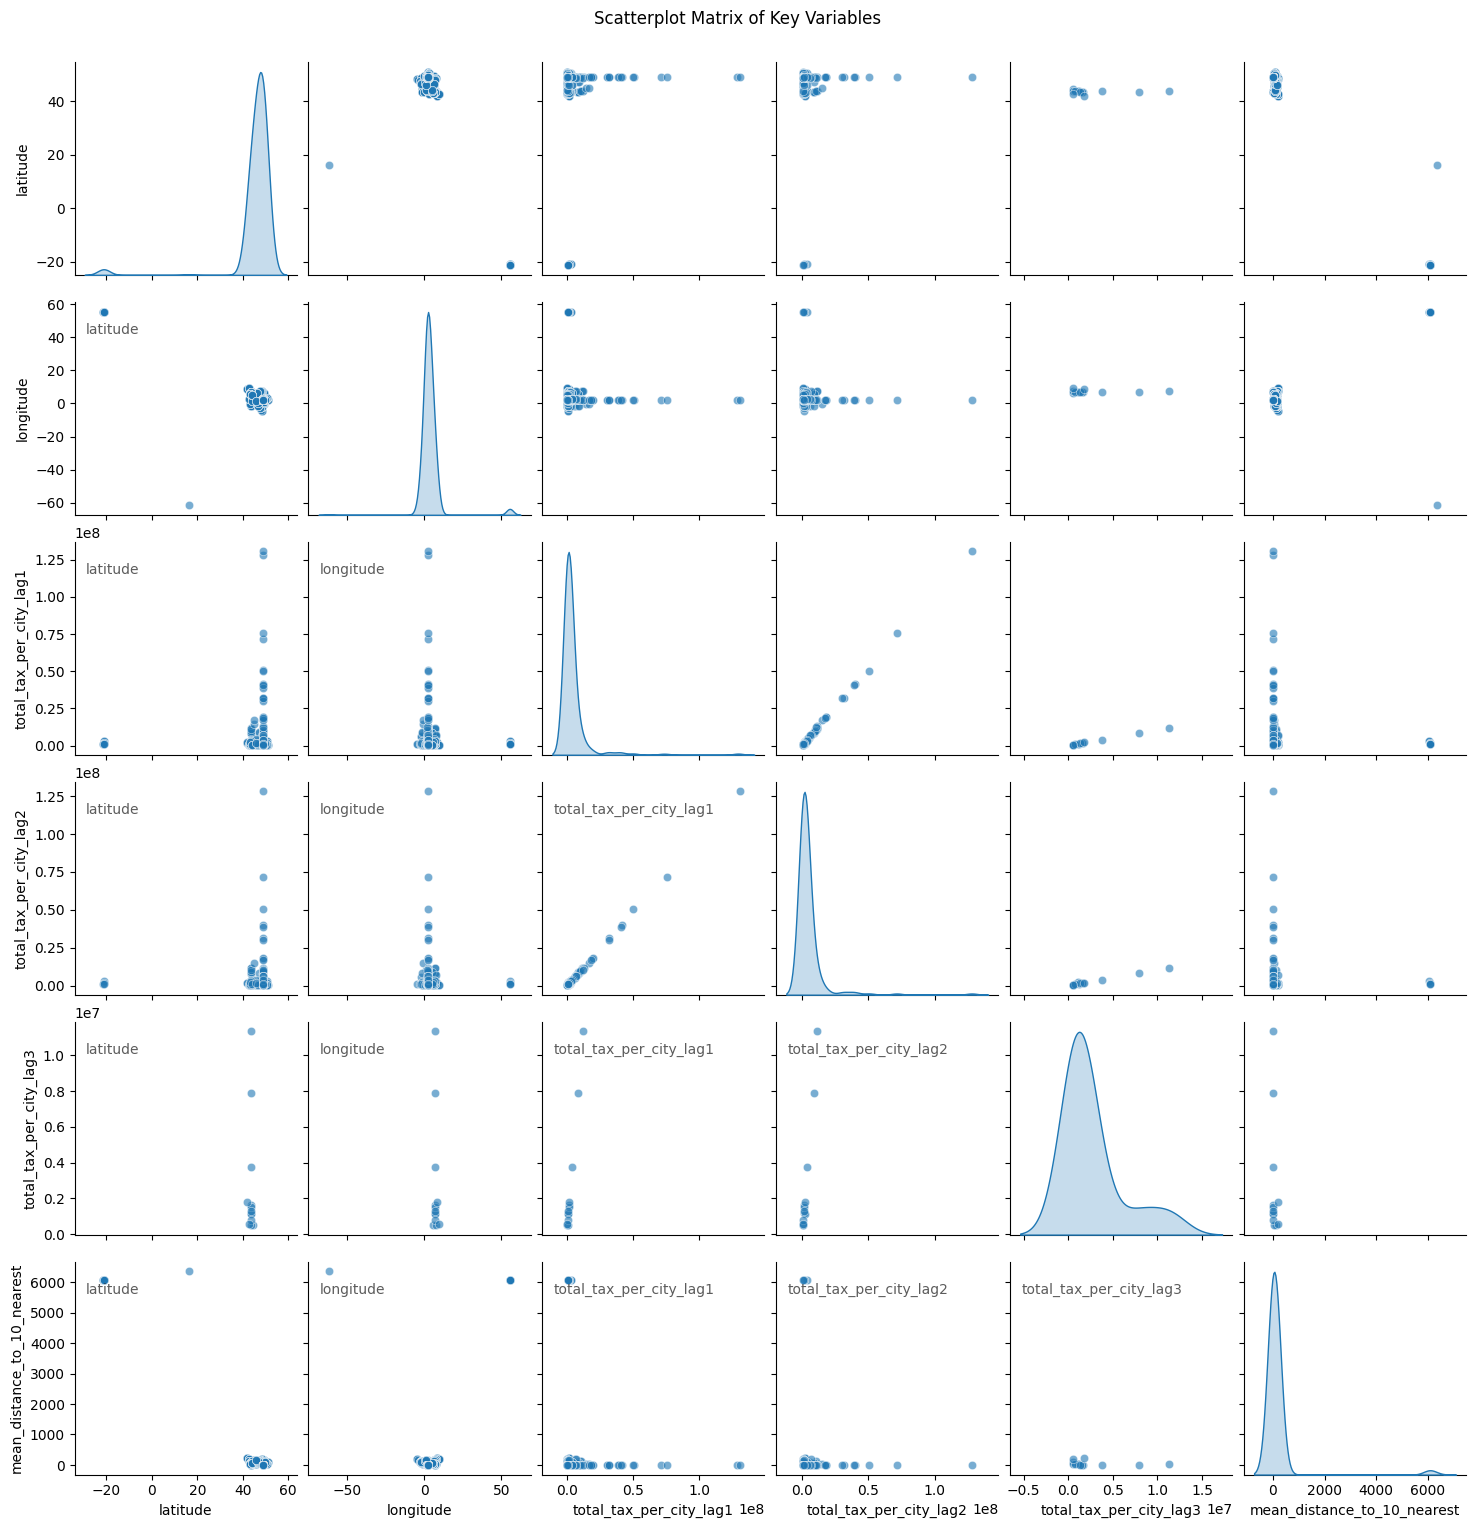

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Selecting a subset of columns for the pairplot
subset = df_ificom_clean[['latitude', 'longitude', 'total_tax_per_city_lag1', 'total_tax_per_city_lag2', 'total_tax_per_city_lag3', 'mean_distance_to_10_nearest']]

# Create the pairplot
g = sns.pairplot(subset, diag_kind='kde', plot_kws={'alpha': 0.6})

# Loop through the axes to add annotations
for i, row_axes in enumerate(g.axes):
    for j, ax in enumerate(row_axes):
        # Only annotate the lower triangle plots, to avoid overlap with KDE plots
        if i > j:
            ax.annotate(subset.columns[j], xy=(0.05, 0.85), xycoords='axes fraction',
                        fontsize=10, color='#333333', alpha=0.8,
                        fontname='DejaVu Sans', weight='light')

# Display the plot
plt.suptitle('Scatterplot Matrix of Key Variables', y=1.02)
plt.show()


Plot predictor variable

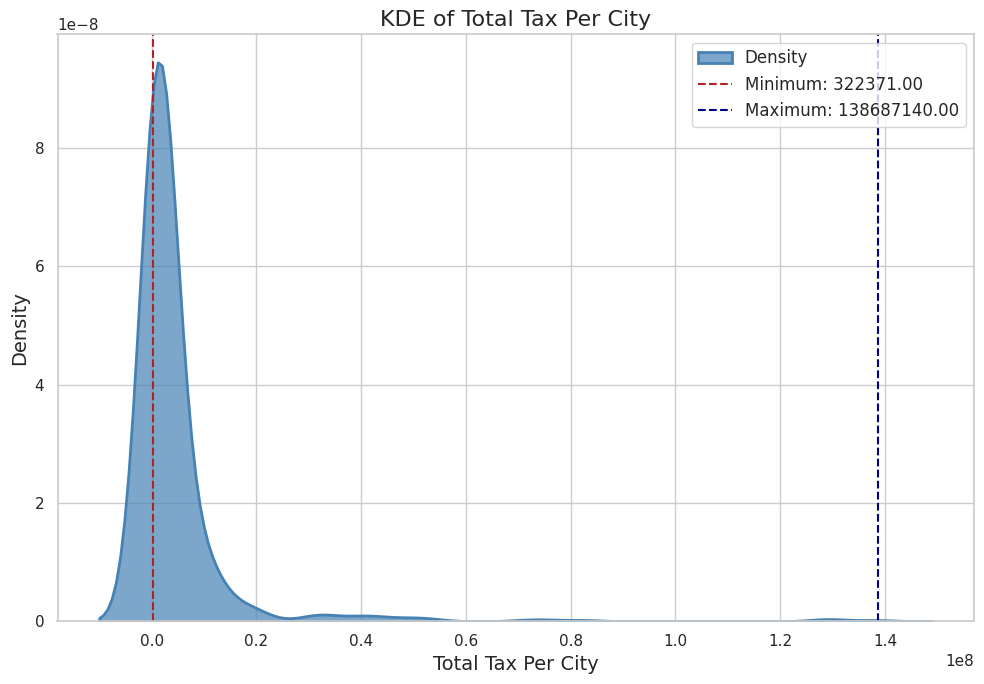

In [13]:
# Plot the Kernel Density Estimation (KDE) of Y variable
import matplotlib.pyplot as plt
import seaborn as sns

# Set up a modern Seaborn theme
sns.set_theme(style="whitegrid")

# Set up the KDE plot with enhanced visuals
plt.figure(figsize=(10, 7))
sns.kdeplot(y, fill=True, color='steelblue', linewidth=2, label='Density', alpha=0.7)
plt.axvline(min(y), color='firebrick', linestyle='--', linewidth=1.5, label=f'Minimum: {min(y):.2f}')
plt.axvline(max(y), color='darkblue', linestyle='--', linewidth=1.5, label=f'Maximum: {max(y):.2f}')
plt.xlabel('Total Tax Per City', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('KDE of Total Tax Per City', fontsize=16)
plt.legend(loc='upper right', fontsize=12)
plt.tight_layout()
plt.show()


Running models

In [14]:
#*****Linear Regression*****
# Imports
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pandas as pd

# Initialize and train the linear regression model
regressor = LinearRegression().fit(X_train, y_train)

# Predictions for test and training datasets
y_pred_test = regressor.predict(X_test)
y_pred_train = regressor.predict(X_train)

# Model evaluation for the test set
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)

# Model evaluation for the training set
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)

# Compile results into a DataFrame
evaluation_metrics = {
    'Model': ['Linear Regression'],
    'MSE_Test': [mse_test],
    'R2_Test': [r2_test],
    'MAE_Test': [mae_test],
    'MSE_Train': [mse_train],
    'R2_Train': [r2_train],
    'MAE_Train': [mae_train]
}

results_df = pd.DataFrame(evaluation_metrics)
results_df

,Model,MSE_Test,R2_Test,MAE_Test,MSE_Train,R2_Train,MAE_Train
0,Linear Regression,5.383242e+12,0.9556,1.091249e+06,1.128833e+13,0.930634,1.290869e+06


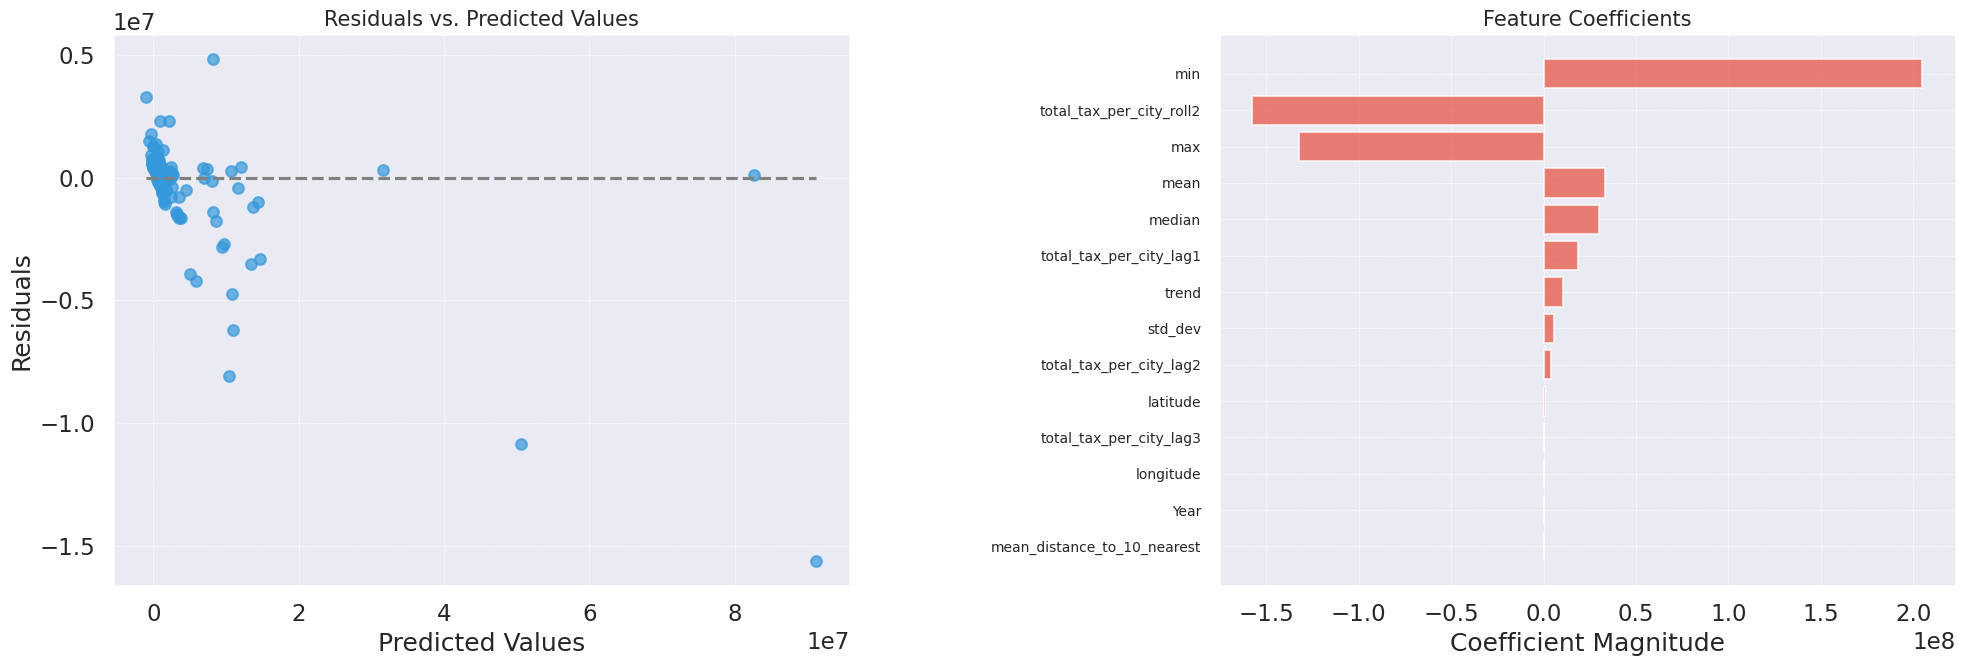

In [15]:
# Seaborn style settings
sns.set_style("darkgrid")
sns.set_context("talk")

# Define colors
colors = ["#3498db", "#e74c3c"]

# Calculate residuals and get coefficients
residuals_test = y_test - y_pred_test
coefficients = regressor.coef_

# Create plots
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

# Residuals vs. Predicted Values
ax[0].scatter(y_pred_test, residuals_test, color=colors[0], alpha=0.7, s=60)
ax[0].hlines(0, y_pred_test.min(), y_pred_test.max(), colors='grey', linestyles='dashed')
ax[0].set_title('Residuals vs. Predicted Values', fontsize=15)
ax[0].set_xlabel('Predicted Values')
ax[0].set_ylabel('Residuals')
ax[0].grid(True, which='both', linestyle='--', linewidth=0.5)

# Feature Coefficients
sorted_idx = np.argsort(np.abs(coefficients))
ax[1].barh(np.array(X.columns)[sorted_idx], coefficients[sorted_idx], color=colors[1], alpha=0.7)
ax[1].set_xlabel('Coefficient Magnitude')
ax[1].set_title('Feature Coefficients', fontsize=15)
ax[1].tick_params(axis='y', labelsize=10)
ax[1].grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjustments
plt.tight_layout()
plt.subplots_adjust(wspace=0.5)
plt.show()

In [16]:
#*****Decision Tree (Adjusted)*****

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pandas as pd

# Initialize and train the decision tree regressor with parameters optimized to prevent overfitting
tree_regressor = DecisionTreeRegressor(max_depth=5, min_samples_split=10, min_samples_leaf=5).fit(X_train, y_train)

# Predictions for test and training datasets
y_pred_test = tree_regressor.predict(X_test)
y_pred_train = tree_regressor.predict(X_train)

# Model evaluation for the test set
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)

# Model evaluation for the training set
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)

# Append results to the existing DataFrame
evaluation_metrics_tree = {
    'Model': ['Decision Tree (Adjusted)'],
    'MSE_Test': [mse_test],
    'R2_Test': [r2_test],
    'MAE_Test': [mae_test],
    'MSE_Train': [mse_train],
    'R2_Train': [r2_train],
    'MAE_Train': [mae_train]
}

new_results = pd.DataFrame(evaluation_metrics_tree)
results_df = pd.concat([results_df, new_results], ignore_index=True)
results_df


,Model,MSE_Test,R2_Test,MAE_Test,MSE_Train,R2_Train,MAE_Train
0,Linear Regression,5.383242e+12,0.955600,1.091249e+06,1.128833e+13,0.930634,1.290869e+06
1,Decision Tree (Adjusted),2.762779e+13,0.772131,1.333255e+06,2.345673e+13,0.855859,1.254437e+06


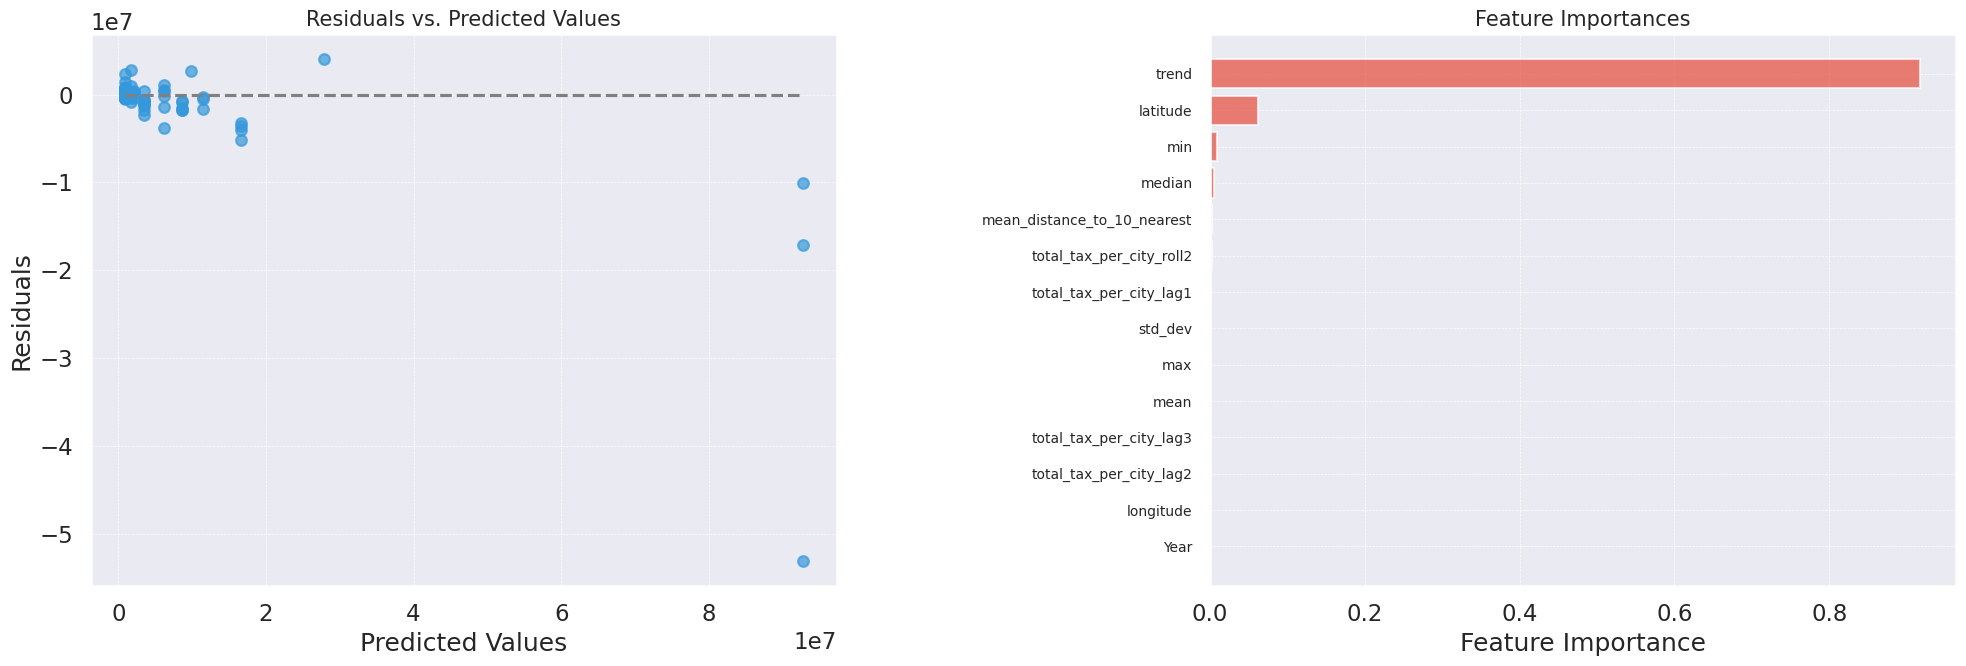

In [17]:
# Set professional dark style with Seaborn
sns.set_style("darkgrid")
colors = ["#3498db", "#e74c3c"]

# Extract feature importances and calculate residuals
feature_importances = tree_regressor.feature_importances_
residuals_test = y_test - y_pred_test

# Create plots
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

# Plot residuals
ax[0].scatter(y_pred_test, residuals_test, color=colors[0], alpha=0.7, s=60)
ax[0].hlines(0, y_pred_test.min(), y_pred_test.max(), colors='grey', linestyles='dashed')
ax[0].set_title('Residuals vs. Predicted Values', fontsize=15)
ax[0].set_xlabel('Predicted Values')
ax[0].set_ylabel('Residuals')
ax[0].grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot feature importances
sorted_idx = np.argsort(feature_importances)
ax[1].barh(np.array(X.columns)[sorted_idx], feature_importances[sorted_idx], color=colors[1], alpha=0.7)
ax[1].set_xlabel('Feature Importance')
ax[1].set_title('Feature Importances', fontsize=15)
ax[1].tick_params(axis='y', labelsize=10)
ax[1].grid(True, which='both', linestyle='--', linewidth=0.5)

# Final adjustments
plt.tight_layout()
plt.subplots_adjust(wspace=0.5)
plt.show()

In [18]:
#Decision tree automatically adjusted

# Auto-adjusted decision tree
from sklearn.model_selection import GridSearchCV

# Define hyperparameter space
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10]
}

# Create the base model
tree_regressor = DecisionTreeRegressor()

# Set up GridSearchCV
grid_search = GridSearchCV(tree_regressor, param_grid, cv=5, scoring='neg_mean_squared_error')

# Train GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best model
best_tree = grid_search.best_estimator_

# Predict with the best model
y_pred = best_tree.predict(X_test)
y_pred_train = best_tree.predict(X_train)

# Evaluate model on test set
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Evaluate model on training set
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)

# Append results to existing DataFrame
new_results = pd.DataFrame({
    'Model': ['Decision Tree (Grid Search)'],
    'MSE_Test': [mse],
    'R2_Test': [r2],
    'MAE_Test': [mae],
    'MSE_Train': [mse_train],
    'R2_Train': [r2_train],
    'MAE_Train': [mae_train]
})

results_df = pd.concat([results_df, new_results], ignore_index=True)
results_df

,Model,MSE_Test,R2_Test,MAE_Test,MSE_Train,R2_Train,MAE_Train
0,Linear Regression,5.383242e+12,0.955600,1.091249e+06,1.128833e+13,0.930634,1.290869e+06
1,Decision Tree (Adjusted),2.762779e+13,0.772131,1.333255e+06,2.345673e+13,0.855859,1.254437e+06
2,Decision Tree (Grid Search),2.848044e+13,0.765099,1.279992e+06,6.829321e+12,0.958034,5.809207e+05


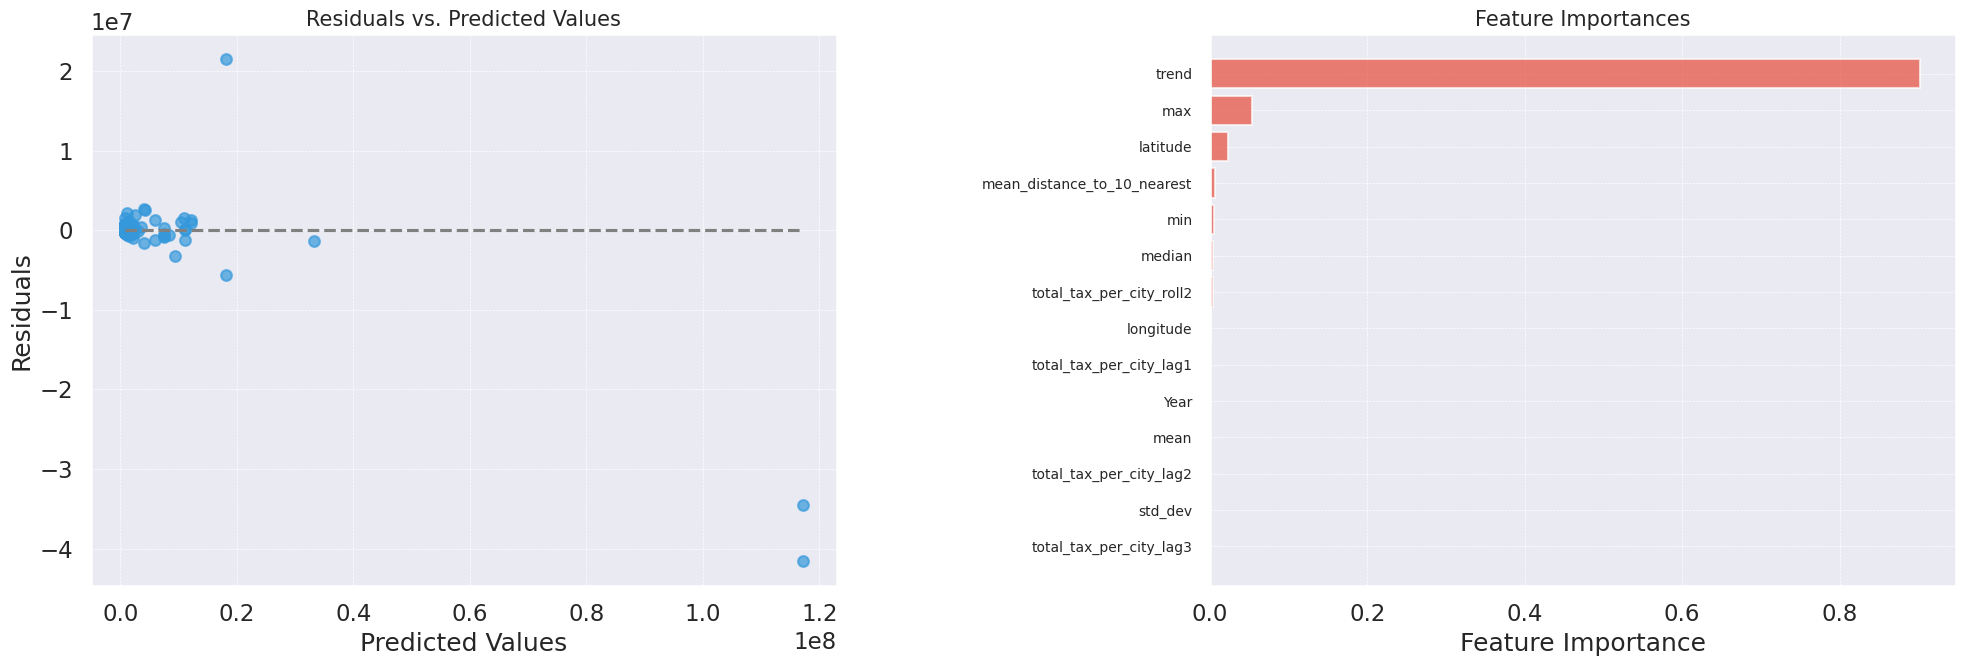

In [19]:
# Set professional dark style with Seaborn
sns.set_style("darkgrid")
colors = ["#3498db", "#e74c3c"]

# Extract feature importances and calculate residuals
feature_importances = best_tree.feature_importances_
residuals_test = y_test - y_pred

# Create plots
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

# Plot residuals
ax[0].scatter(y_pred, residuals_test, color=colors[0], alpha=0.7, s=60)
ax[0].hlines(0, y_pred.min(), y_pred.max(), colors='grey', linestyles='dashed')
ax[0].set_title('Residuals vs. Predicted Values', fontsize=15)
ax[0].set_xlabel('Predicted Values')
ax[0].set_ylabel('Residuals')
ax[0].grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot feature importances
sorted_idx = np.argsort(feature_importances)
ax[1].barh(np.array(X.columns)[sorted_idx], feature_importances[sorted_idx], color=colors[1], alpha=0.7)
ax[1].set_xlabel('Feature Importance')
ax[1].set_title('Feature Importances', fontsize=15)
ax[1].tick_params(axis='y', labelsize=10)
ax[1].grid(True, which='both', linestyle='--', linewidth=0.5)

# Final adjustments
plt.tight_layout()
plt.subplots_adjust(wspace=0.5)
plt.show()


In [20]:
# Random Forest:
from sklearn.ensemble import RandomForestRegressor

# Define hyperparameter space
param_grid_rf = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10]
}

# Initialize base Random Forest model
rf_regressor = RandomForestRegressor()

# Configure GridSearchCV for Random Forest
grid_search_rf = GridSearchCV(rf_regressor, param_grid_rf, cv=5, scoring='neg_mean_squared_error')

# Train GridSearchCV
grid_search_rf.fit(X_train, y_train)

# Extract the optimal model
best_rf = grid_search_rf.best_estimator_

# Make predictions using the optimal model
y_pred_rf = best_rf.predict(X_test)
y_pred_train_rf = best_rf.predict(X_train)

# Evaluate the model on test data
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

# Evaluate the model on training data
mse_train_rf = mean_squared_error(y_train, y_pred_train_rf)
r2_train_rf = r2_score(y_train, y_pred_train_rf)
mae_train_rf = mean_absolute_error(y_train, y_pred_train_rf)

# Append results to existing DataFrame
new_results_rf = pd.DataFrame({
    'Model': ['Random Forest (Grid Search)'],
    'MSE_Test': [mse_rf],
    'R2_Test': [r2_rf],
    'MAE_Test': [mae_rf],
    'MSE_Train': [mse_train_rf],
    'R2_Train': [r2_train_rf],
    'MAE_Train': [mae_train_rf]
})

results_df = pd.concat([results_df, new_results_rf], ignore_index=True)
results_df

,Model,MSE_Test,R2_Test,MAE_Test,MSE_Train,R2_Train,MAE_Train
0,Linear Regression,5.383242e+12,0.955600,1.091249e+06,1.128833e+13,0.930634,1.290869e+06
1,Decision Tree (Adjusted),2.762779e+13,0.772131,1.333255e+06,2.345673e+13,0.855859,1.254437e+06
2,Decision Tree (Grid Search),2.848044e+13,0.765099,1.279992e+06,6.829321e+12,0.958034,5.809207e+05
3,Random Forest (Grid Search),3.629801e+13,0.700621,1.225275e+06,8.275937e+12,0.949145,6.323550e+05


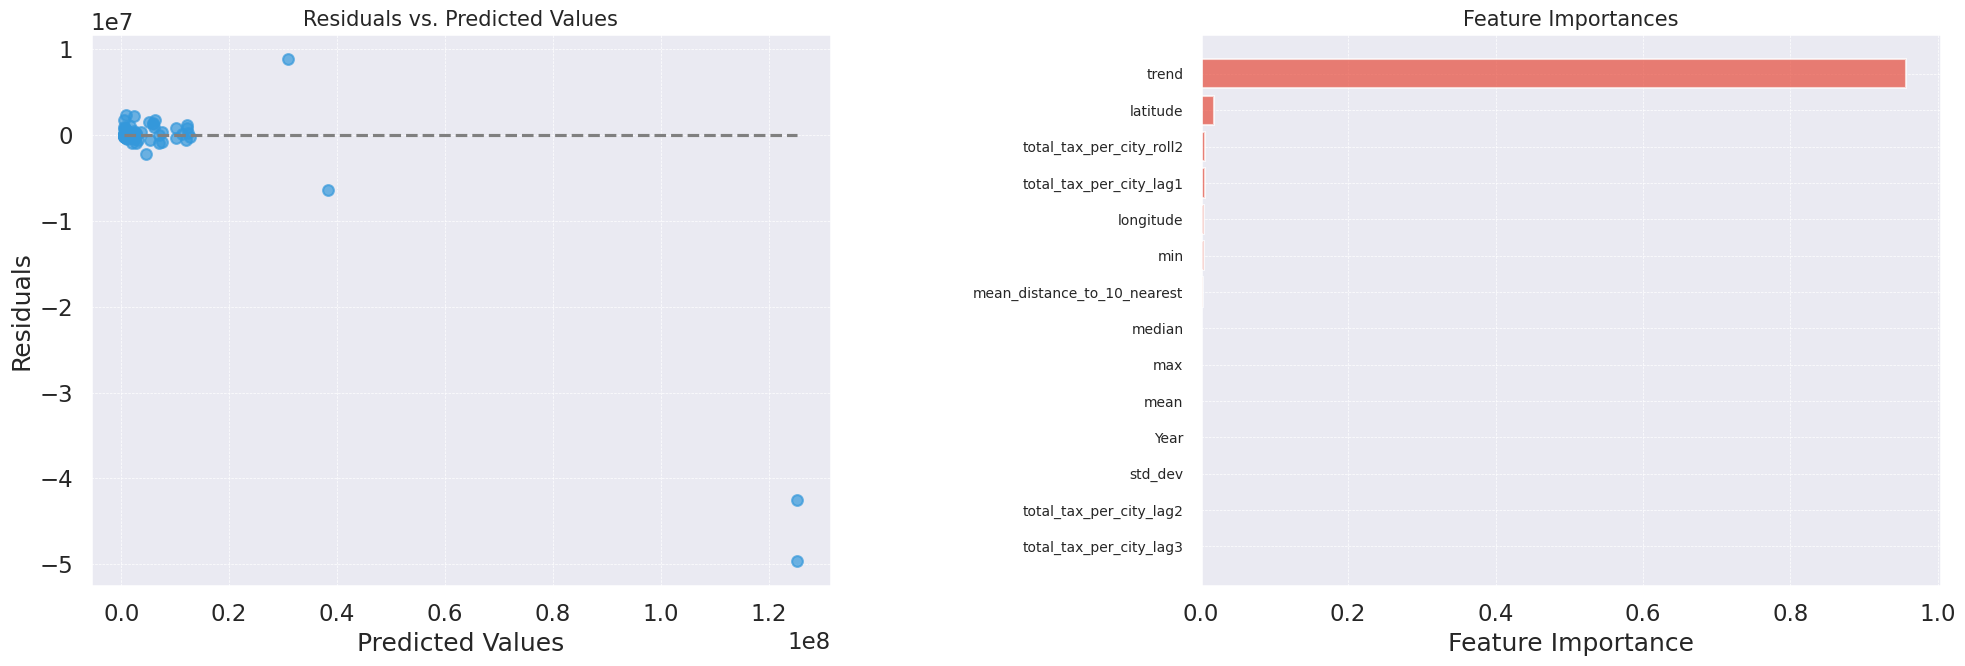

In [21]:
# Set professional dark style with Seaborn
sns.set_style("darkgrid")
colors = ["#3498db", "#e74c3c"]

# Extract feature importances and calculate residuals
feature_importances_rf = best_rf.feature_importances_
residuals_rf = y_test - y_pred_rf

# Create plots
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

# Plot residuals
ax[0].scatter(y_pred_rf, residuals_rf, color=colors[0], alpha=0.7, s=60)
ax[0].hlines(0, y_pred_rf.min(), y_pred_rf.max(), colors='grey', linestyles='dashed')
ax[0].set_title('Residuals vs. Predicted Values', fontsize=15)
ax[0].set_xlabel('Predicted Values')
ax[0].set_ylabel('Residuals')
ax[0].grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot feature importances
sorted_idx_rf = np.argsort(feature_importances_rf)
ax[1].barh(np.array(X.columns)[sorted_idx_rf], feature_importances_rf[sorted_idx_rf], color=colors[1], alpha=0.7)
ax[1].set_xlabel('Feature Importance')
ax[1].set_title('Feature Importances', fontsize=15)
ax[1].tick_params(axis='y', labelsize=10)
ax[1].grid(True, which='both', linestyle='--', linewidth=0.5)

# Final adjustments
plt.tight_layout()
plt.subplots_adjust(wspace=0.5)
plt.show()


In [ ]:
# XGBoost
import xgboost as xgb

# Define hyperparameter space for XGBoost
param_grid_xgb = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'subsample': [0.5, 0.7, 0.9, 1.0],
    'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.25, 0.5, 1.0],
}

# Initialize base XGBoost model
xgb_regressor = xgb.XGBRegressor(tree_method='gpu_hist')

#xgb_regressor = xgb.XGBRegressor()

# Configure GridSearchCV for XGBoost
grid_search_xgb = GridSearchCV(xgb_regressor, param_grid_xgb, cv=5, scoring='neg_mean_squared_error')

# Train GridSearchCV for XGBoost
grid_search_xgb.fit(X_train, y_train)

# Extract the optimal XGBoost model
best_xgb = grid_search_xgb.best_estimator_

# Predict using the optimal model
y_pred_xgb = best_xgb.predict(X_test)
y_pred_train_xgb = best_xgb.predict(X_train)

# Evaluate the model on test data
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

# Evaluate the model on training data
mse_train_xgb = mean_squared_error(y_train, y_pred_train_xgb)
r2_train_xgb = r2_score(y_train, y_pred_train_xgb)
mae_train_xgb = mean_absolute_error(y_train, y_pred_train_xgb)

# Append XGBoost results to the existing DataFrame
new_results_xgb = pd.DataFrame({
    'Model': ['XGBoost (Grid Search)'],
    'MSE_Test': [mse_xgb],
    'R2_Test': [r2_xgb],
    'MAE_Test': [mae_xgb],
    'MSE_Train': [mse_train_xgb],
    'R2_Train': [r2_train_xgb],
    'MAE_Train': [mae_train_xgb]
})

results_df = pd.concat([results_df, new_results_xgb], ignore_index=True)
results_df


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set professional dark style with Seaborn
sns.set_style("darkgrid")
colors = ["#3498db", "#e74c3c"]

# Extract feature importances and calculate residuals
feature_importances_xgb = best_xgb.feature_importances_
residuals_xgb = y_test - y_pred_xgb

# Create plots
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

# Plot residuals
ax[0].scatter(y_pred_xgb, residuals_xgb, color=colors[0], alpha=0.7, s=60)
ax[0].hlines(0, y_pred_xgb.min(), y_pred_xgb.max(), colors='grey', linestyles='dashed')
ax[0].set_title('Residuals vs. Predicted Values (XGBoost)', fontsize=15)
ax[0].set_xlabel('Predicted Values')
ax[0].set_ylabel('Residuals')
ax[0].grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot feature importances
sorted_idx_xgb = np.argsort(feature_importances_xgb)
ax[1].barh(np.array(X.columns)[sorted_idx_xgb], feature_importances_xgb[sorted_idx_xgb], color=colors[1], alpha=0.7)
ax[1].set_xlabel('Feature Importance')
ax[1].set_title('Feature Importances (XGBoost)', fontsize=15)
ax[1].tick_params(axis='y', labelsize=10)
ax[1].grid(True, which='both', linestyle='--', linewidth=0.5)

# Final adjustments
plt.tight_layout()
plt.subplots_adjust(wspace=0.5)
plt.show()


In [ ]:
#NN model

#!pip install keras-tuner

from kerastuner import HyperModel, RandomSearch

class NNHyperModel(HyperModel):
    def __init__(self, input_dim):
        self.input_dim = input_dim

    def build(self, hp):
        model = tf.keras.models.Sequential()

        model.add(tf.keras.layers.Dense(units=hp.Int('units_input', min_value=32, max_value=256, step=32),
                                        activation='relu', input_dim=self.input_dim))

        for i in range(hp.Int('n_layers', 1, 5)):
            model.add(tf.keras.layers.Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32),
                                            activation='relu'))

        model.add(tf.keras.layers.Dense(1))
        optimizer = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])
        model.compile(optimizer=optimizer, loss='mean_squared_error')

        return model

hypermodel = NNHyperModel(input_dim=X_train.shape[1])

tuner = RandomSearch(
    hypermodel,
    objective='val_loss',
    max_trials=30,
    executions_per_trial=2,
    directory='nn_hyperopt',
    project_name='NN_tuning'
)

tuner.search_space_summary()

tuner.search(X_train, y_train, epochs=50, validation_split=0.2, verbose=1, callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])

best_model = tuner.get_best_models(num_models=1)[0]


# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose=1, callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])

# Predict with the best model
y_pred_nn = model.predict(X_test).flatten()
y_pred_train_nn = model.predict(X_train).flatten()

# Evaluate the model on the test set
mse_nn = mean_squared_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)
mae_nn = mean_absolute_error(y_test, y_pred_nn)

# Evaluate the model on the training set
mse_train_nn = mean_squared_error(y_train, y_pred_train_nn)
r2_train_nn = r2_score(y_train, y_pred_train_nn)
mae_train_nn = mean_absolute_error(y_train, y_pred_train_nn)

# Add the results to an existing DataFrame
new_results_nn = pd.DataFrame({
    'Model': ['Optimized Neural Network'],
    'MSE_test': [mse_nn],
    'R2_test': [r2_nn],
    'MAE_test': [mae_nn],
    'MSE_train': [mse_train_nn],
    'R2_train': [r2_train_nn],
    'MAE_train': [mae_train_nn]
})

results_df = pd.concat([results_df, new_results_nn], ignore_index=True)
results_df


In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
# Predecir en el conjunto de prueba
y_pred = rf_model.predict(X_test)

In [ ]:
# Calcular métricas de evaluación
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse, r2

(732207322662.9633, 0.9944670072402058)

iperparameters

In [ ]:
from sklearn.model_selection import GridSearchCV

# Definir los hiperparámetros a optimizar
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)
best_rf_model = grid_search.best_estimator_


Fitting 3 folds for each of 144 candidates, totalling 432 fits


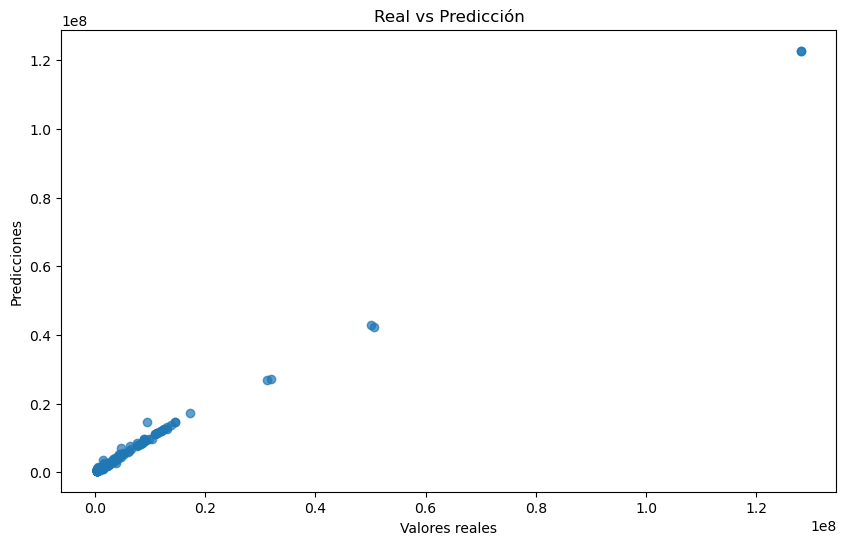

In [ ]:
import matplotlib.pyplot as plt

# Predecir con el mejor modelo
y_pred_optimized = best_rf_model.predict(X_test)

# Visualizar los resultados
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_optimized, alpha=0.7)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Real vs Predicción')
plt.show()


In [ ]:
mse_optimized = mean_squared_error(y_test, y_pred_optimized)
r2_optimized = r2_score(y_test, y_pred_optimized)
print(f"MSE Optimizado: {mse_optimized}")
print(f"R^2 Optimizado: {r2_optimized}")


MSE Optimizado: 912951207456.0309
R^2 Optimizado: 0.9931011992579801


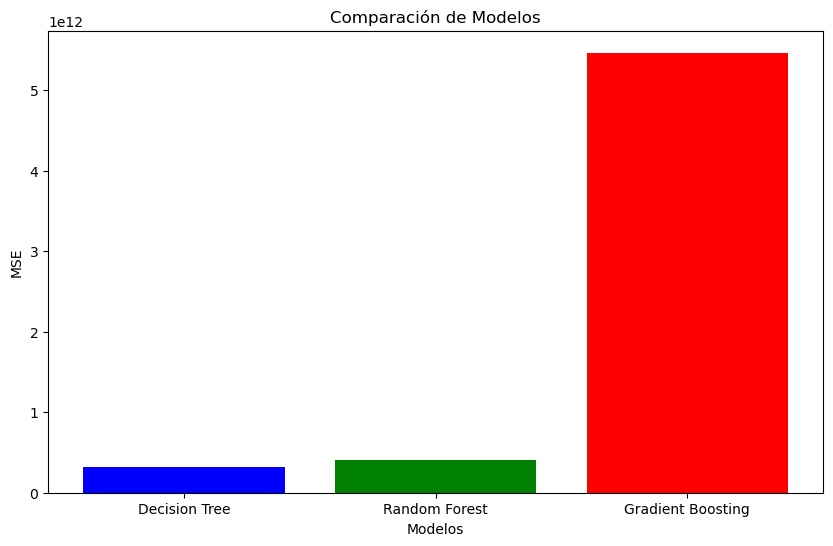

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

# Lista de modelos para evaluar
models = [
    ('Decision Tree', DecisionTreeRegressor()),
    ('Random Forest', RandomForestRegressor(n_estimators=100)),
    ('Gradient Boosting', GradientBoostingRegressor(n_estimators=100))
]

# Entrena y evalúa cada modelo
model_names = []
mse_scores = []

for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    model_names.append(name)
    mse_scores.append(mse)

# Visualiza los resultados
plt.figure(figsize=(10, 6))
plt.bar(model_names, mse_scores, color=['blue', 'green', 'red'])
plt.xlabel('Modelos')
plt.ylabel('MSE')
plt.title('Comparación de Modelos')
plt.show()


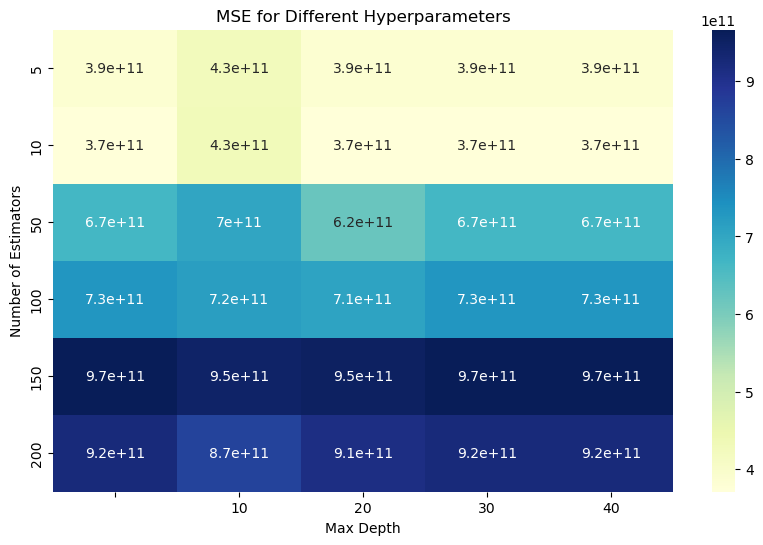

In [ ]:
import numpy as np
import seaborn as sns

# Define rangos para los hiperparámetros
n_estimators_range = [5,10, 50, 100, 150, 200]
max_depth_range = [None, 10, 20, 30, 40]

# Matriz para almacenar los resultados
mse_results = np.zeros((len(n_estimators_range), len(max_depth_range)))

# Entrena el modelo para cada combinación y almacena el MSE
for i, n_estimators in enumerate(n_estimators_range):
    for j, max_depth in enumerate(max_depth_range):
        rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        mse_results[i, j] = mean_squared_error(y_test, y_pred)

# Visualiza los resultados en un gráfico de calor
plt.figure(figsize=(10, 6))
sns.heatmap(mse_results, annot=True, cmap='YlGnBu',
            xticklabels=max_depth_range, yticklabels=n_estimators_range)
plt.xlabel('Max Depth')
plt.ylabel('Number of Estimators')
plt.title('MSE for Different Hyperparameters')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 2. Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
X = df_ificom[['latitude', 'longitude', 'Year']]
y = df_ificom['total_tax_per_city']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# 3. Construir el modelo con TensorFlow
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(3,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mse')

In [ ]:
# 4. Entrenar el modelo
model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_data=(X_test_scaled, y_test))


Epoch 1/100
39/39 [==============================] - 3s 25ms/step - loss: 161214499913728.0000 - val_loss: 84532959117312.0000
Epoch 2/100
39/39 [==============================] - 0s 11ms/step - loss: 161214516690944.0000 - val_loss: 84532950728704.0000
Epoch 3/100
39/39 [==============================] - 1s 16ms/step - loss: 161214483136512.0000 - val_loss: 84532950728704.0000
Epoch 4/100
39/39 [==============================] - 1s 16ms/step - loss: 161214516690944.0000 - val_loss: 84532950728704.0000
Epoch 5/100
39/39 [==============================] - 1s 22ms/step - loss: 161214516690944.0000 - val_loss: 84532950728704.0000
Epoch 6/100
39/39 [==============================] - 1s 15ms/step - loss: 161214499913728.0000 - val_loss: 84532950728704.0000
Epoch 7/100
39/39 [==============================] - 0s 10ms/step - loss: 161214516690944.0000 - val_loss: 84532950728704.0000
Epoch 8/100
39/39 [==============================] - 0s 11ms/step - loss: 161214516690944.0000 - val_loss: 8453

In [ ]:
# 5. Predecir los valores para los próximos 5 años para cada ciudad
years_to_predict = np.array([df_ificom['Year'].max() + i for i in range(1, 6)])
predictions = {}

for city in df_ificom['Commune_Code_INSEE'].unique():
    city_data = df_ificom[df_ificom['Commune_Code_INSEE'] == city].iloc[0]
    for year in years_to_predict:
        input_data = np.array([city_data['latitude'], city_data['longitude'], year]).reshape(1, -1)
        input_data_scaled = scaler.transform(input_data)
        prediction = model.predict(input_data_scaled)
        predictions[(city, year)] = prediction[0][0]

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 230ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 159ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 337ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 148ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 76ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 174ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 123ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 92ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 181ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 82ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 210ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 106ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 111ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 85ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 87ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 123ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 73ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 87ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 67ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 93ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 63ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 176ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 69ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 81ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 78ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 73ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 85ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 97ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 104ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 90ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 126ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 65ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 183ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 78ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 91ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 61ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 64ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 43ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 124ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 122ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 64ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 47ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 44ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 45ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 79ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 56ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 209ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 78ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 68ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 107ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 78ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 118ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 74ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 174ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 61ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 133ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 103ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 86ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 93ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 116ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 76ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 114ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 192ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 96ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 93ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 90ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 82ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 70ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 61ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 73ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 248ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 47ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 82ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 60ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 72ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 40ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 48ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 49ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 92ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 105ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 98ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 72ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 104ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 174ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 117ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 118ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 97ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 72ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 101ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 39ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 67ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 59ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 179ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 88ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 64ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 240ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 64ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 142ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 71ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 177ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 298ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 401ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 198ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 240ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 193ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 161ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 247ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 542ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 182ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 742ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 145ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 153ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 196ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 106ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 303ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 207ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 84ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 179ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 383ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 462ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 219ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 244ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 176ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 86ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 267ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 748ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 256ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 144ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 115ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 156ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 654ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 82ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 131ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 77ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 101ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 93ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 95ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 206ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 86ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 92ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 106ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 102ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 118ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 145ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 140ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 93ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 94ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 164ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 116ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 109ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 69ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 85ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 130ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 188ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 60ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 82ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 89ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 81ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 63ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 66ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 212ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 98ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 77ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 97ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 81ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 95ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 62ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 87ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 75ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 97ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 114ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 74ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 59ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 59ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 57ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 68ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 72ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 64ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 61ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 68ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 98ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 61ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 72ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 88ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 62ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 68ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 63ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 72ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 137ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 58ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 79ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 59ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 63ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 487ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 418ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 58ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 57ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 105ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 88ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 38ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 73ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 198ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 80ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 100ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 86ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 64ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 108ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 58ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 63ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 70ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 62ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 45ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 59ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 49ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 48ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 49ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 49ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 73ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 84ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 57ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 87ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 59ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 57ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 56ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 57ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 56ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 56ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 56ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 57ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 56ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 78ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 48ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 47ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 58ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 61ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 57ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 88ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 78ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 60ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 82ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 85ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 65ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 69ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 56ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 69ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 62ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 59ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 58ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 301ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 142ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 59ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 71ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 75ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 57ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 62ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 77ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 98ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 66ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 131ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 57ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 76ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 63ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 63ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 56ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 67ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 109ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 172ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 74ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 88ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 69ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 96ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 60ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 127ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 232ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 65ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 93ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 198ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 566ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 159ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 58ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 60ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 74ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 68ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 49ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 62ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 63ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 47ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 69ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 57ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 91ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 75ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 70ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 47ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 48ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 59ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 49ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 58ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 60ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 61ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 66ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 64ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 60ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 48ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 56ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 231ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 75ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 102ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 89ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 216ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 99ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 216ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 68ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 124ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 119ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 143ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 91ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 215ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 98ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 106ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 77ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 72ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 94ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 62ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 47ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 73ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 59ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 127ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 105ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 105ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 70ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 64ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 57ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 108ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 69ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 62ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 48ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 59ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 48ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 61ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 75ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 61ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 64ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 68ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 61ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 57ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 58ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 59ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 58ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 58ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 58ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 38ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 57ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 61ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 48ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 57ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 49ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 62ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 56ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 66ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 57ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 66ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 57ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 62ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 57ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 64ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 100ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 57ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 58ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 57ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 69ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 69ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 49ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 59ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 46ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 47ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 49ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 49ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 77ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 58ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 49ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 61ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 66ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 49ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 181ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 69ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 63ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 56ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 59ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 59ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 56ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 56ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 63ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 47ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 49ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 56ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 47ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 64ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 107ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 66ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 49ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 59ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 172ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 64ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 68ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 118ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 60ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 56ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 70ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 61ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 58ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 49ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 49ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 64ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 61ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 88ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 61ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 48ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 46ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 70ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 94ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 169ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 57ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 65ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 66ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 70ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 59ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 214ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 39ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 68ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 77ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 58ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 68ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 58ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 79ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 60ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 46ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 105ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 67ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 57ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 65ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 60ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 173ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 58ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 57ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 78ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 60ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 61ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 57ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 49ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 53ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 47ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 48ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 48ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 43ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 44ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 72ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 77ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 115ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 56ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 49ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 46ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 48ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 102ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 49ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 47ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 57ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 79ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 49ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 57ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 56ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 70ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 138ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 47ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 264ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 48ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 48ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 48ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 178ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 48ms/step


c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\santi\anaconda3\envs\tf_ifi_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


In [ ]:
# 2. Importación de bibliotecas
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import keras_tuner
from kerastuner.tuners import RandomSearch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Preprocesamiento
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X = scaler_X.fit_transform(df_ificom[['latitude', 'longitude', 'Year']])
y = scaler_y.fit_transform(df_ificom[['total_tax_per_city']])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Seleccionando las columnas de interés
df_model = df_ificom[['latitude', 'longitude', 'Year', 'total_tax_per_city']]

# Normalizando las características
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X = scaler_X.fit_transform(df_model[['latitude', 'longitude', 'Year']])
y = scaler_y.fit_transform(df_model[['total_tax_per_city']])

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1221, 3), (306, 3), (1221, 1), (306, 1))

In [ ]:
X = df_ificom[['latitude', 'longitude', 'Year']]
y = df_ificom['total_tax_per_city']

id=df_ificom[['Commune_Code_INSEE','Year']]


In [ ]:
# Dividir los datos en conjuntos de entrenamiento y prueba
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar los datos
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_Y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_Y.transform(y_test.values.reshape(-1, 1))


In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score

# Hacer predicciones con el conjunto de prueba
y_pred = model.predict(X_test_scaled)

# Transformar las predicciones y los valores verdaderos al rango original
y_pred_original = scaler_Y.inverse_transform(y_pred)
y_test_original = scaler_Y.inverse_transform(y_test_scaled)

# Calcular MAE y R^2
mae = mean_absolute_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)

print(f"MAE: {mae}")
print(f"R^2: {r2}")


10/10 [==============================] - 1s 12ms/step
MAE: 4020642.401960784
R^2: -0.014273395138171718


In [ ]:
history = model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=32, validation_data=(X_test_scaled, y_test_scaled))


Epoch 1/100
39/39 [==============================] - 4s 27ms/step - loss: 0.0086 - val_loss: 0.0039
Epoch 2/100
39/39 [==============================] - 0s 11ms/step - loss: 0.0075 - val_loss: 0.0039
Epoch 3/100
39/39 [==============================] - 0s 9ms/step - loss: 0.0074 - val_loss: 0.0038
Epoch 4/100
39/39 [==============================] - 0s 12ms/step - loss: 0.0074 - val_loss: 0.0038
Epoch 5/100
39/39 [==============================] - 0s 10ms/step - loss: 0.0074 - val_loss: 0.0038
Epoch 6/100
39/39 [==============================] - 0s 8ms/step - loss: 0.0074 - val_loss: 0.0038
Epoch 7/100
39/39 [==============================] - 0s 8ms/step - loss: 0.0074 - val_loss: 0.0039
Epoch 8/100
39/39 [==============================] - 0s 7ms/step - loss: 0.0074 - val_loss: 0.0038
Epoch 9/100
39/39 [==============================] - 0s 7ms/step - loss: 0.0074 - val_loss: 0.0038
Epoch 10/100
39/39 [==============================] - 0s 8ms/step - loss: 0.0075 - val_loss: 0.0039
Epoch

In [ ]:
import numpy as np

years_to_predict = np.array([2023, 2024, 2025, 2026, 2027])

predictions = []

for year in years_to_predict:
    latest_data = X[-3:].append(pd.DataFrame({'latitude': [43.309129], 'longitude': [3.484479], 'Year': [year]}))
    scaled_data = scaler_X.transform(latest_data)
    prediction = model.predict(scaled_data)[-1]
    predictions.append(scaler_Y.inverse_transform(prediction))

predictions


AttributeError: 'DataFrame' object has no attribute 'append'

#Making prediction with best model  (1/ 2 and 3 years) (in test data)

#Someway graph prediction, results, comapration with reals

#Make full predicition  (train with all data and no test only show the cities )and main trends citiss, (as firts explriation graphs )

#Saving data for PowerBI graphically representation